<a href="https://colab.research.google.com/github/KhawajaMuddassar/object_detection-and-image-classification/blob/main/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basics of Object Detection Concepts**

Object detection is a computer vision technique that identifies and localizes multiple objects within an image. It involves two key components: classification, where each detected object is assigned a class label (e.g., "car," "person," "dog"), and localization, where the algorithm generates bounding boxes around each detected object, indicating their positions within the image.

Object detection is commonly used in various applications, such as autonomous vehicles, security surveillance, image annotation, and robotics, enabling machines to understand and interact with their visual environment effectively. Advanced algorithms like **YOLO (You Only Look Once)**, **R-CNN** and **Faster R-CNN** are often employed to perform object detection efficiently.

**Training a typical object detection model involves the following steps:**


1.   Creating ground-truth data that contains labels of the bounding box and class corresponding to various objects present in the image
2.    Creating a mechanism that identify regions that are likly to contain objects, and known as Region Proposals
3.     Creating the target class variable by using the IoU metric
4.    Creating the target bounding-box offset variable to make corrections to the location of the region proposal in step 2
5.    Building and train a model that can predict the class of object along with the target bounding-box offset corresponding to the region proposal
6.    Measuring the accuracy of object detection using **mean average precision (mAP)**

**Region Proposals and SelectiveSearch Algorithm:**

A Region Proposal is a technique used in computer vision, particularly in object detection, to suggest potential areas in an image where objects might be located. These proposals are generated through algorithms named as **SelectiveSearch** that analyze the image and create bounding boxes around potential object locations. SelectiveSearch over-segments an image by grouping pixels based on the preceding attributes. Then, it iterates through these over-segmented groups and groups them based on similarity. At each
iteration, it combines smaller regions to form a larger region.


**Intersection over Union (IoU):**
Intersection over Union (IoU) is a metric used in object detection to measure how well a predicted bounding box matches the ground truth bounding box for an object.

In technical terms, it calculates the overlap between the area of the predicted box and the actual box that surrounds the object. The IoU is expressed as a ratio: the area of overlap divided by the area of the union (the total area covered by both boxes).

A higher IoU value (close to 1) means the predicted box is very accurate, while a lower value (close to 0) indicates a poor match.

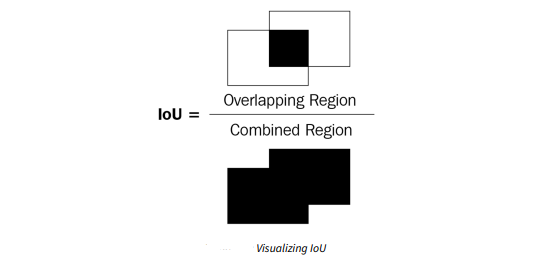

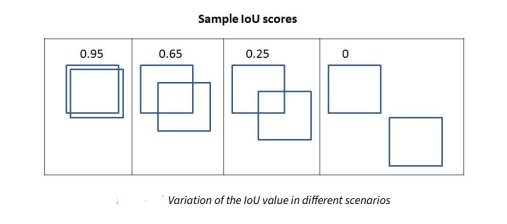

**Non-max suppression:**
Non-max refers to the boxes that don't have the highest probability of containing an object, and suppression refers to us discarding those boxes. In non-max suppression, we identify the bounding box that
has the highest probability of containing the object and discard all the other bounding boxes that have an IoU below a certain threshold

**Mean average precision:**

mAP is the average of precision values calculated at various IoU threshold values across all the classes of objects present within a dataset.

# **Implementing R-CNN object detector**

# **Download Dataset**

In [ ]:
%pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
from torch_snippets.torch_loader import Report, Dataset, DataLoader
from torchvision import transforms, models, datasets
import cv2, torch, torchvision
import torch.nn as nn
from torch.optim import SGD
from torchvision.ops import nms
import selectivesearch
from google.colab import files
import warnings
warnings.filterwarnings(action='ignore')
files.upload() # upload kaggle.json file which you can get
# by clicking on Create New API token in your personal account
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Read ground truth present in dataset file
root_folder = 'images/images'
root_data = pd.read_csv('df.csv')
root_data.head()

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 86.8 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json
kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks/versions/
License(s): unknown
100% 366M/367M [00:21<00:00, 21.7MB/s]
100% 367M/367M [00:21<00:00, 17.7MB/s]


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


# **Preparing Dataset**

This involves following steps:



1.   Fetching values of each image, its class and bounding -box
2.   Fetching RoPs within each image, thier IoU, and delta by which RoP will be correct w.r.t ground truth
3.   Assigning numeric labels for each class, also for additional background classes besides bus and truck classes where IoU with ground truth is bounding-box is lower than threshold
4.   Resizing each RoP to comman size so that we can pass it to network

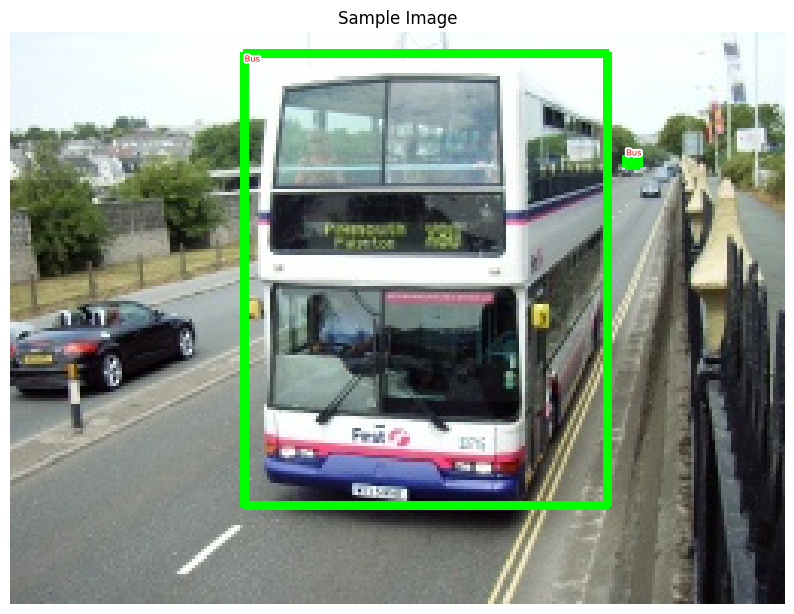

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

# Define class that return image, classes and ground truth along with filepath of image
class OpenImages(Dataset):
    def __init__(self, data, image_folder = root_folder):
        self.folder = image_folder
        self.data = data
        self.unique_images = data['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self,xi):
        imageid = self.unique_images[xi]
        image_path = f'{self.folder}/{imageid}.jpg'
        image = cv2.imread(image_path,1)[...,::-1] # Convert BGR to RGB
        h,w = image.shape[:2]
        df = self.data.copy()
        df = df[df['ImageID']==imageid]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes*np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path

# Initialize Dataset and Inspect sample, of image, its class and bounding box
ds = OpenImages(data=root_data)
im, bbs, clas, _ = ds[90]
show(im, bbs=bbs, texts=clas, sz=10, title='Sample Image')

#Define functions to extract IoU and to fetch region of proposal (RoP) from images
def get_candidate(image):
    label, regions = selectivesearch.selective_search(image, scale=200, min_size=100)
    area = np.prod(image.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*area): continue
        if r['size'] > (1*area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

def get_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width =  (x2 - x1)
    height = (y2 - y1)
    if (width <0) or (height<0):
        return 0.0
    overlap_area = width * height
    a_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    b_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    combined_area = a_area + b_area - overlap_area
    iou = overlap_area / (combined_area + epsilon)
    return iou


# **Fetch region proposals and the ground truth of offset**

Input and Output corresponding to our model

**Input** = Candidate that are extracted using Selectivesearch

**Output** = Class coresponding to candidate and offset of candidate w.r.t bounding box it overlaps most with if the candiate has an object.

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]

#Loop through dataset to populate above lists
image_count = 1000
for xi, (img, bbs, labels, fpath) in enumerate(ds): # Loop thorugh dataset
    if (xi==image_count):
        break
    # Extract candidate for each region and convert it to (x,y,x+w, y+h)
    H, W,_ = img.shape
    candidates = get_candidate(img)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    # Create lists to store for each candidate's ious, rios, bbs deltas, class for each image
    ious, rois, clss, deltas = [], [], [], []
    # extract ious for all candidates w.r.t all ground truth of image and bounding boxes
    ious = np.array([[ get_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    # Loop through each candidate
    for ix, candidate in enumerate(candidates):
        cx,cy, cX,cY = candidate
        #Extract candidate w.r.t all ground truth bounding boxes
        candidate_ious = ious[ix]
        best_iou_at = np.argmax(candidate_ious) # Index of best candidate(Highest IOU)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at] # BB coresponding to this above index
        # Assign Class and backgroound (threshold 30%)
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else: clss.append('background')
        # Calculate Offset to transform current region proposal into best candidate for region proposal
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate/ np.array([W,H,W,H]))
    # Append to lists
    FPATHS.append(fpath)
    CLSS.append(clss)
    IOUS.append(ious)
    GTBBS.append(bbs)
    ROIS.append(rois)
    DELTAS.append(deltas)

# Fetch image path names and store all information obtained
FPATHS = [f'{root_folder}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

#Assign Indices to each class
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

# **Generate training data**


*   Create Dataset from ground truth region of proposals
*   Create Data Loaders
*   Resize region proposals to normalization and scaling them

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Define function for preprocessing image
def preprocess(image):
    image = torch.tensor(image).permute(2,0,1)
    image = normalize(image)
    return image.to(device).float()

# Define function to decode predictions
def decode(_y):
    _, prediction = _y.max(-1)
    return prediction

# Define Dataset class based on ground truth of region proposals
class RCNNDataSet(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gttbs = gtbbs
        self.labels = labels
        self.deltas = deltas
        self.rois = rois
    def __len__(self): return len(self.fpaths)
    #Fetch crops as per rois, class and offsets
    def __getitem__(self,xi):
        fpath = str(self.fpaths[xi])
        image = cv2.imread(fpath,1)[...,::-1]
        H,W,_ = image.shape
        shape = np.array([W,H,W,H])
        rois = self.rois[xi]
        bbs = (np.array(rois)*shape).astype(np.uint16)
        gtbbs = self.gttbs[xi]
        labels = self.labels[xi]
        deltas = self.deltas[xi]
        crops = [image[y:Y, x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs,fpath
# Define function for Resizing and Normalizing batch of crop image
    def get_collate(self,batch):
        input, labels, deltas = [],[],[]
        for xi in range(len(batch)):
            image, crops, bbs, image_labels, delta, gtbbs, fpath = batch[xi]
            crops = [cv2.resize(crop,(224,224)) for crop in crops]
            crops = [preprocess(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[label] for label in image_labels])
            deltas.extend(delta)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

# Create traning and validation datasets and DataLoaders
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataSet(
                        FPATHS[:n_train],
                        ROIS[:n_train],
                        CLSS[:n_train],
                        DELTAS[:n_train],
                        GTBBS[:n_train])
validation_ds = RCNNDataSet(
                        FPATHS[n_train:],
                        ROIS[n_train:],
                        CLSS[n_train:],
                        DELTAS[n_train:],
                        GTBBS[n_train:])

# Data Loaders
train_loader = DataLoader(train_ds, batch_size=2,  collate_fn=train_ds.get_collate, drop_last=True)
validation_loader = DataLoader(validation_ds, drop_last=True,batch_size=2, collate_fn=validation_ds.get_collate)

# **Build R-CNN network Architecture**

Now we will build and train the model as mentioned above in STPE-5, that can predict both the class of a region proposal and the offset corresponding to it to draw a bounding-box arround object present in image.Our approach to develop such model will be as follows:


1.   Define VGG16 as backbone (to perform Transfer Learning)
2.   Get the features by passing the normalized crops through a pretrained model
3.   Add a linear layer with a sigmoid activation (Tanh) to the VGG backbone which help predict the class for the region proposal
4.   Add an extra linear layer to estimate the four offsets for the bounding box
5.   Define loss function for both outputs i-e one to predict the class and other to predict 4 bounding-box offset
6.   Train the model to predict both outputs


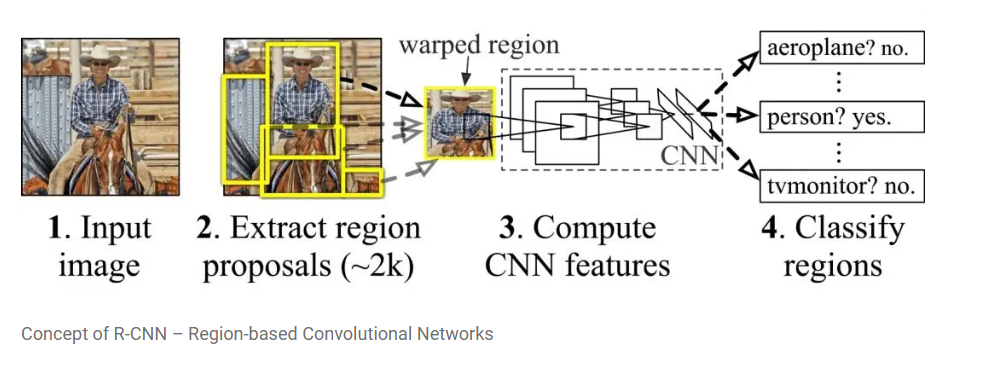


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 107MB/s]


EPOCH: 5.000  val_loss: 1.202  val_loc_loss: 0.085  val_regr_loss: 0.112  val_acc: 0.986  (2856.32s - 0.00s remaining)

100%|██████████| 106/106 [00:00<00:00, 951.06it/s]


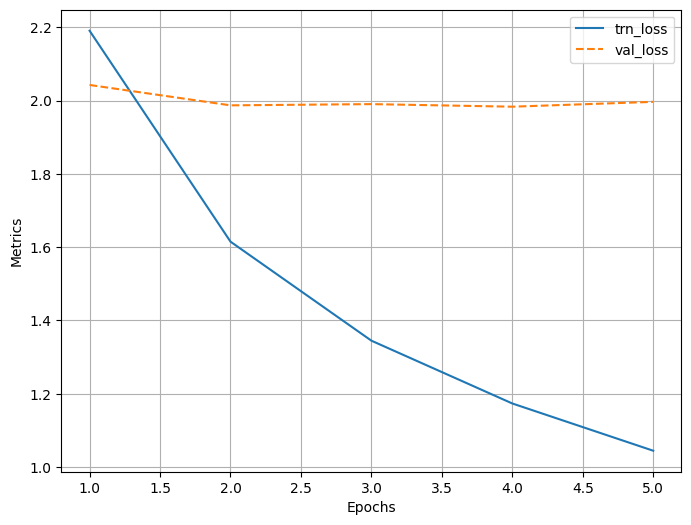

In [ ]:
# VGG Backbone
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

# Define RCNN Network Module class
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512,4),
            nn.Tanh())
        self.cel = nn.CrossEntropyLoss() # Classification loss
        self.sl1 = nn.L1Loss() # Regression smooth loss

    # Define feed-forward method to pass images through backbone
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox

    # Loss function calculation, which return sum of detection and regression loss also ignored regression loss for background class
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs = torch.where(labels != 0) # Ignore background class
        _deltas = _deltas[ixs] # filtering
        deltas = deltas[ixs]
        self.lmb = 10.0  # short form of Lambda, a Hyper-parameter to control/balance the trade-off between loss components
        if len(ixs)>0:
            regression_loss = self.sl1(_deltas,deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss , detection_loss.detach(), regression_loss

# Define function to train model on batch of data and predict on validation data
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss,_deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

# Define function to validate batch using validation data
@torch.no_grad()
def validate_batch(input, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss, = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()


# Instantiate model as object, fetch the loss criterion, and define optimizer and epochs
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = torch.optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

# Train model
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,trn_regr_loss=regr_loss,trn_acc=accs.mean(), end='\r')

    _n = len(validation_loader)
    for ix,inputs in enumerate(validation_loader):
        _clss, _deltas, loss, loc_loss, regr_loss, accs = validate_batch(inputs,rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,val_regr_loss=regr_loss,val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))



# **Make prediction on a test image**

After model is trained we will use test data to make predictions on new images to draw bounding-box arround object presentin image and predict their coresponding class.we will adop following strategy:


1.   we will first extract region proposals from new image
2.   Secondly resize and normalize each crop
3.   Feed-forward the processed crops to predict the class and the offsets
4.   Perform Non-Max suppression to fetch only box which has highest probabilty


In [ ]:
# Define function that take images as INPUT and ground truth bounding box
def test_predictions(filename, show_output=True):
    # Read image and extract candidates
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = get_candidate(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    # Resize and preprocess image
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess(crop/255.)[None])
    input = torch.cat(input).to(device)
    # Predict Class and offset
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
        # Exclude background class and sum up candidate BB with predicted BB offset values
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    # Apply Non-Max suppression , pair of boxes having IoU >0.05 are considered as duplicate
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    # Fetch bounding-box with highest confidence
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    # Plot image along with predicted bounding box
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf

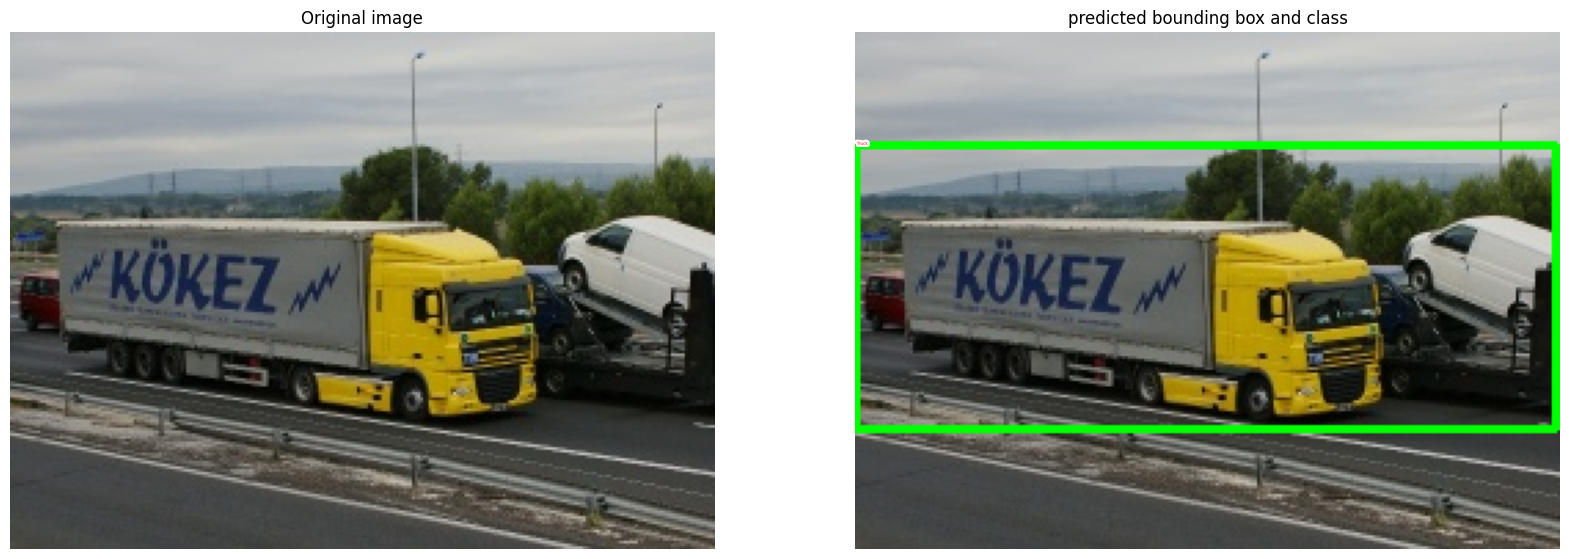

((0, 41, 254, 144), 'Truck', 0.9906329)

In [ ]:
image, crops, bbs, labels, deltas, gtbbs, fpath = validation_ds[12]
test_predictions(fpath)